<a href="https://colab.research.google.com/github/imiro/bangkit_finalproject/blob/master/edible_wild_plants_mobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Packages & Libraries
import os
import zipfile
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

# Download dataset to /content/datasets

In [ ]:
# Getting the image dataset: Edible wild plants by gverzea on Kaggle
# Kaggle credentials
!mkdir /root/.kaggle
!echo '{"username":"nprdny","key":"c24037553f9bda47644115fb6d109f2c"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Kaggle dataset
!kaggle datasets download -d gverzea/edible-wild-plants

!ls

#unzipping the zip files and deleting the zip files
!unzip -q \*.zip  && rm *.zip

100% 765M/766M [00:12<00:00, 73.3MB/s]
100% 766M/766M [00:12<00:00, 61.8MB/s]
edible-wild-plants.zip	sample_data


In [ ]:
# Checking what's inside the dataset
labels = os.listdir('/content/datasets/dataset/')

'''# Automating label print
labels_nospace = []

for label in labels:
  labels_nospace.append(label.replace(" ", ""))

#print(type(labels_nospace))

labels_list = '_traindir\n'.join(labels_nospace)

print(labels_list)'''

'# Automating label print\nlabels_nospace = []\n\nfor label in labels:\n  labels_nospace.append(label.replace(" ", ""))\n\n#print(type(labels_nospace))\n\nlabels_list = \'_traindir\n\'.join(labels_nospace)\n\nprint(labels_list)'

# EDA

In [ ]:
train_dir = '/content/datasets/dataset'
val_dir = '/content/datasets/dataset-test'

In [ ]:
labels = os.listdir(train_dir)

train_files = {}
for lab in labels:
  train_files[lab] = os.listdir(os.path.join(train_dir, lab))

In [ ]:
print('Total files for each label')
'''for lab in labels:
  print(lab, len(train_files[lab]), len(os.listdir(os.path.join(val_dir,lab))))'''

Total files for each label


'for lab in labels:\n  print(lab, len(train_files[lab]), len(os.listdir(os.path.join(val_dir,lab))))'

In [ ]:
# Sunflower 735, Daisy Fleabane 770, Dandellion 1053
# all else either 50, 100, 150

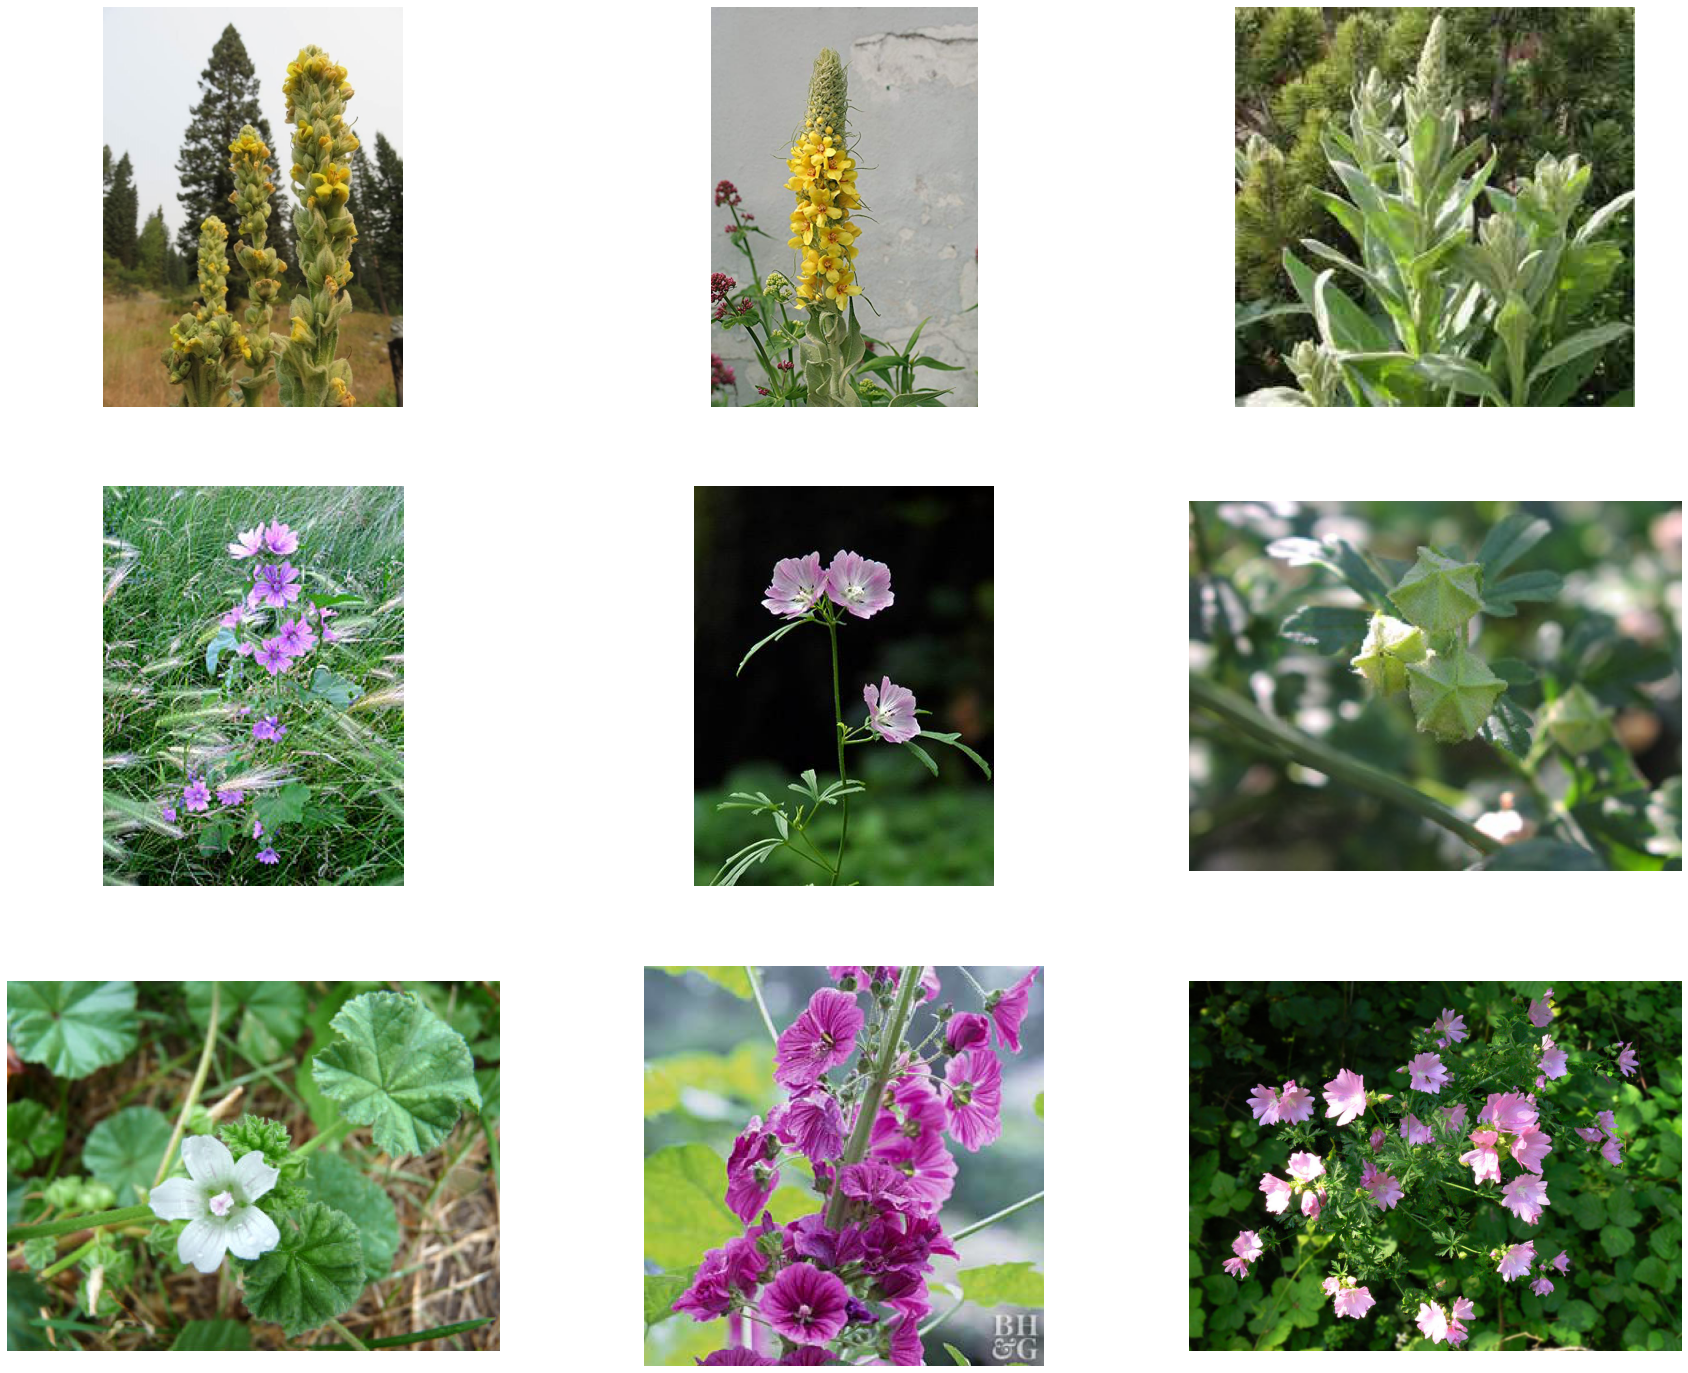

In [ ]:
# Let's try visualizing some of them
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# let's try Wild Grapevine, Japanese Knotweed, Mallow
play_labels = ['Mullein', 'Vervain Mallow', 'Mallow']

pic_id = 33
pic_filenames = {}
for l in play_labels:
  ldir = os.path.join(train_dir,l)
  pic_filenames[l] = [os.path.join(ldir,fname) for fname in os.listdir(ldir)[pic_id-3:pic_id]]

plt.figure(figsize=(30,25))
cnt = 1
for label in pic_filenames:
  for f in pic_filenames[label]:
    plt.subplot(3,3,cnt)
    img = mpimg.imread(f)
    plt.imshow(img)
    plt.axis('Off')
    # plt.show()
    cnt += 1
plt.show()

## (iseng?) Dimensions of the images

In [ ]:
import numpy as np

dimensions = []
for the_plant in train_files:
  """this loop took quite some time.. it reads all the images!"""
  for fname in train_files[the_plant]:
    ffname = os.path.join(train_dir, the_plant, fname)
    pimg = mpimg.imread(ffname)
    dimensions.append(pimg.shape[:2])

#print (dimensions[:10])

#dim_array = np.array(dimensions)

#print(min(dim_array))

In [ ]:
dims = np.array(dimensions)

print(dims)

# dimsUnique, dimsCount = dims.unique(return_counts=True)
dimsCount = {} # Numbers of dimensions available
minDim = 2500
for d in dimensions:
  dkey = "%d,%d" % d
  minDim = min(minDim, min(d[0],d[1]))
  if dkey in dimsCount:
    dimsCount[dkey] += 1
  else:
    dimsCount[dkey] = 1

dimsCount = sorted(dimsCount.items(), key=lambda x: x[1], reverse=True)

#print('Number of dimensions available = ', len(dimsCount))
#print('Smallest dimension available = ', minDim)

'''for i in range(60):
  print(dimsCount[i][0], dimsCount[i][1])'''

[[463 463]
 [375 375]
 [451 640]
 ...
 [500 375]
 [367 600]
 [266 200]]


'for i in range(60):\n  print(dimsCount[i][0], dimsCount[i][1])'

# Data Generator

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

img_size = 160

train_dir = '/content/datasets/dataset'
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_dir = '/content/datasets/dataset-test'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(img_size, img_size),
	class_mode='categorical',
  batch_size=50
)

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(img_size, img_size),
	class_mode='categorical',
  batch_size=50
)

Found 6558 images belonging to 62 classes.
Found 310 images belonging to 62 classes.


# Model

Transfer learning with MobileNetV2 + class weights for handling imbalance

In [ ]:
validation_dir = val_dir

image_size = 224 # All images will be resized to 224x224
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator( preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, #rescale=1./255,
                                                              horizontal_flip=True,
                                                              width_shift_range = 0.2,
                                                              height_shift_range = 0.2,
                                                              rotation_range = 40,
                                                              shear_range = 0.2,
                                                              zoom_range = 0.2,
                                                              fill_mode='nearest')

validation_datagen = keras.preprocessing.image.ImageDataGenerator(
                                                 preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input # ,rescale=1./255
                                                 )

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use categorical_crossentropy loss, we need categorical labels
                class_mode='categorical')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
dirml = '/content/gdrive/My Drive/Bangkit Academy/EWP3/SavedModel' 
!mkdir -p "$dirml"

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

tensorboard= TensorBoard(log_dir='Tensorboard',
                            histogram_freq=0, 
                            batch_size=32, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None,
                            embeddings_data=None)

# stop training as soon as the validaion loss does not change significantly. 
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=0, 
                              mode='auto', 
                              baseline=None)

checkpoint_path = os.path.join(dirml, 'weights.best.hdf5')
# Create checkpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                                              monitor='val_loss', 
                                              verbose=1, 
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='min', #min for loss and max for accuracy
                                              period=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[2.11548387 1.05774194 2.11548387 2.11548387 2.11548387 2.11548387
 0.70516129 2.11548387 2.11548387 2.11548387 1.05774194 2.11548387
 2.11548387 1.05774194 2.11548387 0.70516129 0.13736908 0.10045033
 2.11548387 1.05774194 2.11548387 2.11548387 1.05774194 2.11548387
 2.11548387 1.05774194 2.11548387 0.70516129 2.11548387 2.11548387
 2.11548387 2.11548387 2.11548387 0.70516129 2.11548387 2.11548387
 2.11548387 2.11548387 2.11548387 2.11548387 2.11548387 0.70516129
 2.11548387 2.11548387 2.11548387 1.05774194 2.11548387 2.11548387
 2.11548387 1.05774194 2.11548387 0.14391047 2.11548387 2.11548387
 2.11548387 1.05774194 2.11548387 2.11548387 2.11548387 1.05774194
 1.05774194 2.11548387]


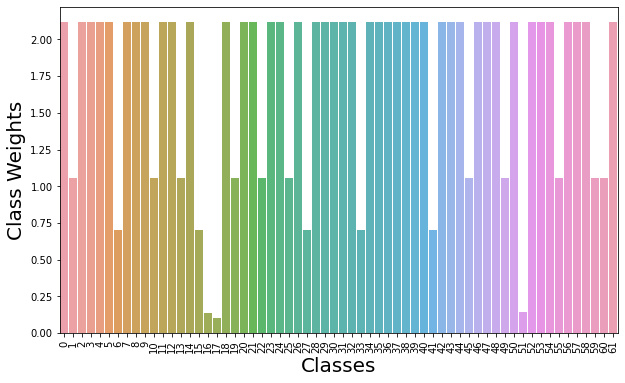

In [ ]:
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

plt.figure(figsize = (10,6))
sns.barplot(np.unique(train_generator.classes), class_weights, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Classes', fontsize =20)
plt.ylabel('Class Weights', fontsize = 20)
plt.show()

class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model Resnet 50
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')


base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
import tensorflow.keras as keras 

num_classes = 62
rate = 0.20

model3 = tf.keras.Sequential([
  base_model, # Resnet 50
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(rate), # add drop out layer
  keras.layers.Dense(num_classes, activation='softmax')
])

model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'top_k_categorical_accuracy'])


model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 62)                79422     
Total params: 2,337,406
Trainable params: 79,422
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model3.fit( train_generator, 
                      steps_per_epoch = steps_per_epoch,
                      epochs=epochs, 
                      workers=8,
                      class_weight= class_weights,
                      callbacks = [tensorboard, early_stopping, checkpoint],
                      validation_data=validation_generator, 
                      validation_steps=validation_steps )

Epoch 1/50
204/204 [==============================] - ETA: 0s - loss: 4.3885 - accuracy: 0.1033 - top_k_categorical_accuracy: 0.2605
Epoch 00001: val_loss improved from inf to 3.90160, saving model to /content/gdrive/My Drive/Bangkit Academy/EWP3/SavedModel/weights.best.hdf5
204/204 [==============================] - 98s 480ms/step - loss: 4.3885 - accuracy: 0.1033 - top_k_categorical_accuracy: 0.2605 - val_loss: 3.9016 - val_accuracy: 0.0951 - val_top_k_categorical_accuracy: 0.2171
Epoch 2/50
204/204 [==============================] - ETA: 0s - loss: 3.7403 - accuracy: 0.2384 - top_k_categorical_accuracy: 0.4440
Epoch 00002: val_loss improved from 3.90160 to 3.42403, saving model to /content/gdrive/My Drive/Bangkit Academy/EWP3/SavedModel/weights.best.hdf5
204/204 [==============================] - 98s 481ms/step - loss: 3.7403 - accuracy: 0.2384 - top_k_categorical_accuracy: 0.4440 - val_loss: 3.4240 - val_accuracy: 0.1537 - val_top_k_categorical_accuracy: 0.4024
Epoch 3/50
204/204 [

In [ ]:
tf.saved_model.save(model3, dirml)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Bangkit Academy/EWP3/SavedModel/assets


# Convert to TFjs GraphModel

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 144.4MB 74kB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 256kB 42.3MB/s 
     |████████████████████████████████| 921kB 44.5MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=1241b57f888e0674afdd1d60ef838d15ffa254cbdc8eaab48aea85b04aa88f5a
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: tensorflow-hub 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dirml = '/content/drive/My Drive/Bangkit Academy/EWP3/SavedModel'

In [ ]:
!mkdir EWP3
!cp -R "$dirml" ./EWP3

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model ./EWP3/SavedModel ./EWP3/tfjs_model

2020-06-22 16:32:31.138349: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-06-22 16:32:31.143777: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200000000 Hz
2020-06-22 16:32:31.144052: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1848a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-06-22 16:32:31.144127: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-06-22 16:32:37.694439: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2020-06-22 16:32:37.694669: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-06-22 16:32:37.730684: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:797] 

In [ ]:
import os
parent_dirml = os.path.join(dirml, '..')
parent_dirml

'/content/drive/My Drive/Bangkit Academy/EWP3/SavedModel/..'

In [ ]:
!cp -R ./EWP3/tfjs_model "{parent_dirml}"